# **Fruits and Vegetables Quality**

## **Powered by 42RandomState**

### **Install old libraries for compatibility**

In [1]:
!pip install -U scikit-learn imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 99.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.


## **1) Work on data**

In [2]:
import os
import glob
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import img_to_array, to_categorical, load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

input_dir = "/kaggle/input/fruitquality1/Unified_Dataset"
image_size = (128,128)

# 1 Load images + preprocessing in a function
def load_images_from_folder(base_dir):
    X, y = [], []
    for fruit in os.listdir(base_dir):
        for condition in ["fresh", "rotten"]:
            class_name = f"{fruit}_{condition}"
            class_dir = os.path.join(base_dir, fruit, condition)
            if not os.path.isdir(class_dir): continue
            for img_path in glob.glob(os.path.join(class_dir, "*.jpg")):
                try:
                    img = load_img(img_path, target_size=image_size)
                    img = img_to_array(img) / 255.0
                    X.append(img)
                    y.append(class_name)
                except:
                    continue
    return np.array(X, dtype="float32"), np.array(y)

X, y = load_images_from_folder(input_dir)

# 2 Label encoding (con salvataggio)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3 Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 4 Oversampling
X_train_flat = X_train.reshape((X_train.shape[0], -1))
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_flat, y_train)
X_train = X_resampled.reshape((-1, *image_size, 3))
y_train = y_resampled

# 5 One-hot encoding
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

2025-06-01 11:16:53.123735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748776613.325653      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748776613.384435      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

## **2) Set the model**

In [4]:
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# 8 Model architecture
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
for layer in base_model.layers[:-10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
predictions = Dense(y_train_cat.shape[1], activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

I0000 00:00:1748776898.476035      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## **3) Train the model**

In [5]:
# 9 Callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

# 10 Training
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=64),
    validation_data=(X_val, y_val_cat),
    epochs=40,
    callbacks=[checkpoint, early_stopping, lr_scheduler],
    class_weight=class_weights_dict
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40


I0000 00:00:1748776913.787185      68 service.cc:148] XLA service 0x792a94002970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748776913.787801      68 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748776914.861457      68 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1748776917.359591      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748776917.558696      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748776917.759295      68 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  1/782 ━━━━━━━━━━━━━━━━━━━━ 3:52:09 18s/step - accuracy: 0.0312 - loss: 7.2304 - precision: 0.1000 - recall: 0.0156

I0000 00:00:1748776921.147727      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


228/782 ━━━━━━━━━━━━━━━━━━━━ 1:54 207ms/step - accuracy: 0.5764 - loss: 3.4664 - precision: 0.7750 - recall: 0.4542

E0000 00:00:1748776970.516947      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748776970.718321      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748776970.917442      65 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7415 - loss: 2.2032 - precision: 0.8568 - recall: 0.6637
Epoch 1: val_loss improved from inf to 1.53804, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 194s 226ms/step - accuracy: 0.7416 - loss: 2.2020 - precision: 0.8569 - recall: 0.6639 - val_accuracy: 0.7278 - val_loss: 1.5380 - val_precision: 0.7424 - val_recall: 0.7215 - learning_rate: 0.0010
Epoch 2/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.9258 - loss: 0.4663 - precision: 0.9450 - recall: 0.9052
Epoch 2: val_loss improved from 1.53804 to 0.63707, saving model to best_model.keras
782/782 ━━━━━━━━━━━━━━━━━━━━ 160s 205ms/step - accuracy: 0.9258 - loss: 0.4663 - precision: 0.9450 - recall: 0.9052 - val_accuracy: 0.8991 - val_loss: 0.6371 - val_precision: 0.9079 - val_recall: 0.8985 - learning_rate: 0.0010
Epoch 3/40
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.9387 - loss: 0.3914 - precision: 0.9530 - recall: 0.9235
Epoch 3: val_los

## **4) Visualize the training**

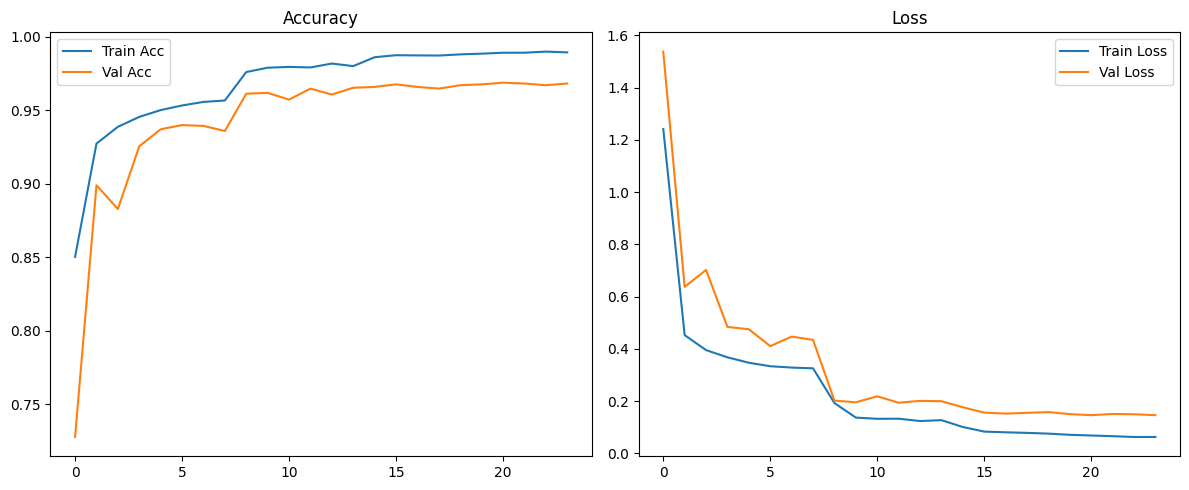

In [6]:
def plot_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

## **5) Test the model on the test set**

55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step

Classification Report:

                    precision    recall  f1-score   support

       apple_fresh       0.94      1.00      0.97        32
      apple_rotten       0.95      0.91      0.93        58
      banana_fresh       1.00      1.00      1.00        80
     banana_rotten       1.00      0.98      0.99        57
  bellpepper_fresh       0.98      0.92      0.95        60
 bellpepper_rotten       0.88      0.85      0.86        59
      carrot_fresh       0.92      0.95      0.93        60
     carrot_rotten       0.95      0.93      0.94        58
    cucumber_fresh       0.95      0.90      0.92        59
   cucumber_rotten       0.86      0.89      0.88        56
       grape_fresh       1.00      0.95      0.97        20
      grape_rotten       0.95      1.00      0.98        20
       guava_fresh       1.00      1.00      1.00        20
      guava_rotten       0.87      1.00      0.93        20
      jujube_fresh       0.95     

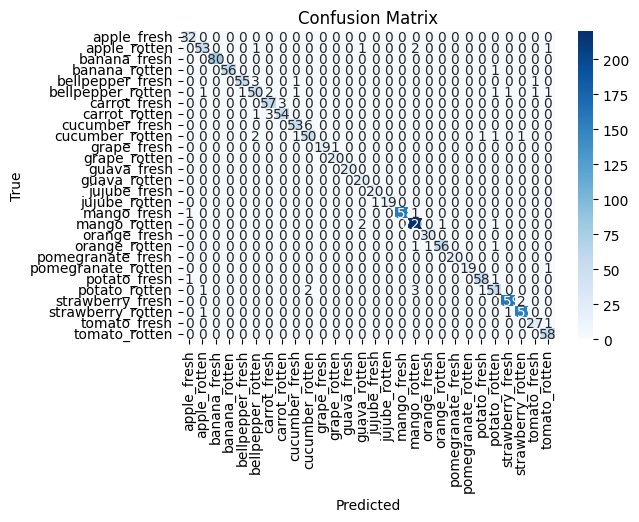

ROC AUC Score: 0.9988
Weighted F1 Score: 0.9625


In [7]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from tensorflow.keras.utils import to_categorical

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_test

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC e F1 Score
y_true_cat = to_categorical(y_true)
roc_auc = roc_auc_score(y_true_cat, y_pred_probs)
f1 = f1_score(y_true, y_pred, average="weighted")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Weighted F1 Score: {f1:.4f}")

## **6) Tuning the thresholds**

In [8]:
num_classes = y_pred_probs.shape[1]
best_thresholds = np.zeros(num_classes)

for i in range(num_classes):
    y_true_bin = (y_true == i).astype(int)
    probs = y_pred_probs[:, i]
    
    best_thresh, best_f1 = 0.0, 0.0
    for thresh in np.arange(0.1, 0.9, 0.05):
        y_pred_bin = (probs >= thresh).astype(int)
        f1 = f1_score(y_true_bin, y_pred_bin)
        if f1 > best_f1:
            best_f1, best_thresh = f1, thresh
    
    best_thresholds[i] = best_thresh
    print(f"Class '{le.classes_[i]}': Best threshold = {best_thresh:.2f}, F1 = {best_f1:.4f}")

def predict_with_thresholds(probs, thresholds):
    preds = []
    for p in probs:
        above = [i for i, prob in enumerate(p) if prob >= thresholds[i]]
        if not above:
            preds.append(np.argmax(p))  # fallback
        else:
            preds.append(max(above, key=lambda i: p[i]))
    return np.array(preds)

y_pred_tuned = predict_with_thresholds(y_pred_probs, best_thresholds)

print("\nClassification Report with tuned thresholds:\n")
print(classification_report(y_true, y_pred_tuned, target_names=le.classes_))

Class 'apple_fresh': Best threshold = 0.70, F1 = 0.9846
Class 'apple_rotten': Best threshold = 0.35, F1 = 0.9298
Class 'banana_fresh': Best threshold = 0.15, F1 = 1.0000
Class 'banana_rotten': Best threshold = 0.20, F1 = 0.9913
Class 'bellpepper_fresh': Best threshold = 0.40, F1 = 0.9483
Class 'bellpepper_rotten': Best threshold = 0.50, F1 = 0.8772
Class 'carrot_fresh': Best threshold = 0.25, F1 = 0.9516
Class 'carrot_rotten': Best threshold = 0.65, F1 = 0.9558
Class 'cucumber_fresh': Best threshold = 0.10, F1 = 0.9412
Class 'cucumber_rotten': Best threshold = 0.80, F1 = 0.9091
Class 'grape_fresh': Best threshold = 0.10, F1 = 0.9756
Class 'grape_rotten': Best threshold = 0.10, F1 = 0.9756
Class 'guava_fresh': Best threshold = 0.10, F1 = 1.0000
Class 'guava_rotten': Best threshold = 0.55, F1 = 0.9756
Class 'jujube_fresh': Best threshold = 0.10, F1 = 0.9756
Class 'jujube_rotten': Best threshold = 0.25, F1 = 0.9744
Class 'mango_fresh': Best threshold = 0.10, F1 = 1.0000
Class 'mango_rotte

## **7) Save the best model and the best thresholds**

In [9]:
model.save('best_model.keras')
joblib.dump({'thresholds': best_thresholds}, 'thresholds.pkl')
joblib.dump(le, "label_encoder.pkl")

#HOW TO LOAD THE MODEL AND USE THE THRESHOLDS

'''
from tensorflow.keras.models import load_model
import joblib

model = load_model('best_model.keras', custom_objects={'Precision': Precision, 'Recall': Recall})
thresholds = joblib.load('thresholds.pkl')['thresholds']
'''

"\nfrom tensorflow.keras.models import load_model\nimport joblib\n\nmodel = load_model('best_model.keras', custom_objects={'Precision': Precision, 'Recall': Recall})\nthresholds = joblib.load('thresholds.pkl')['thresholds']\n"